In [1]:
import datetime 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import pmdarima as pm
from pmdarima.arima import auto_arima

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller

import sklearn.metrics as skmetrics
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

from math import sqrt
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

Importing plotly failed. Interactive plots will not work.


# Helper Functions

In [2]:
#Karsten
def evaluate_ets_model_rmse(X, t_type, s_type, train_size=0):
    if train_size == 0:
        train_size = int(len(X) * 0.80)
    train, test = X[:train_size], X[train_size:]
    
    predictions = list()
    for t in range(len(test)):
        model = ExponentialSmoothing(X[:train_size + t], 
                                     trend=t_type, 
                                     seasonal=s_type, 
                                     seasonal_periods=12)
        model_fit = model.fit()
        yhat = np.asanyarray(model_fit.forecast())[0] #predict one step
        predictions.append(yhat) #store prediction
        # calculate out of sample error
    predictions = np.asarray(predictions).reshape(-1,)
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse

#YangZhou
def evaluate_sarima(X, trend_order, seasonal_order):
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    
    predictions = list()
    for t in tqdm(range(len(test))):
        model = sm.tsa.statespace.SARIMAX(X[:train_size+t], order=trend_order,seasonal_order=seasonal_order)
        res = model.fit(disp=False)
        yhat = res.predict(start=len(X[:train_size+t]), end=len(X[:train_size+t])).iloc[0] #predict one step
 
        predictions.append(yhat) #store prediction
        
        # calculate out of sample error
    predictions = np.asarray(predictions).reshape(-1,)
    test = np.asanyarray(test).reshape(-1,)
    #mae = skmetrics.mean_absolute_error(test, predictions)
    rmse = np.sqrt(skmetrics.mean_squared_error(test, predictions))
    #mape = np.mean(np.abs(test-predictions)/test)
    return rmse

def diff(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff


In [3]:
df = pd.read_csv("zillow-carlifornia.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.head(2)

,Date,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
0,2008-02-29,470000.0,5.29,6.3
1,2008-03-31,441000.0,5.44,6.2


In [4]:
df.tail(2)

,Date,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
105,2016-11-30,NaN,3.47,4.8
106,2016-12-31,NaN,4.07,4.7


In [5]:
hist = df[df.Date < "2016-01-01"].copy()
test = df[df.Date >= "2016-01-01"].copy()
hist=hist.set_index(['Date'])
test=test.set_index(['Date'])

In [6]:
hist.tail(2)

,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
Date,,,
2015-11-30,485750.0,3.69,5.0
2015-12-31,485000.0,3.89,5.1


In [7]:
test.head(2)

,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
Date,,,
2016-01-31,NaN,3.91,5.0
2016-02-29,NaN,3.96,4.9


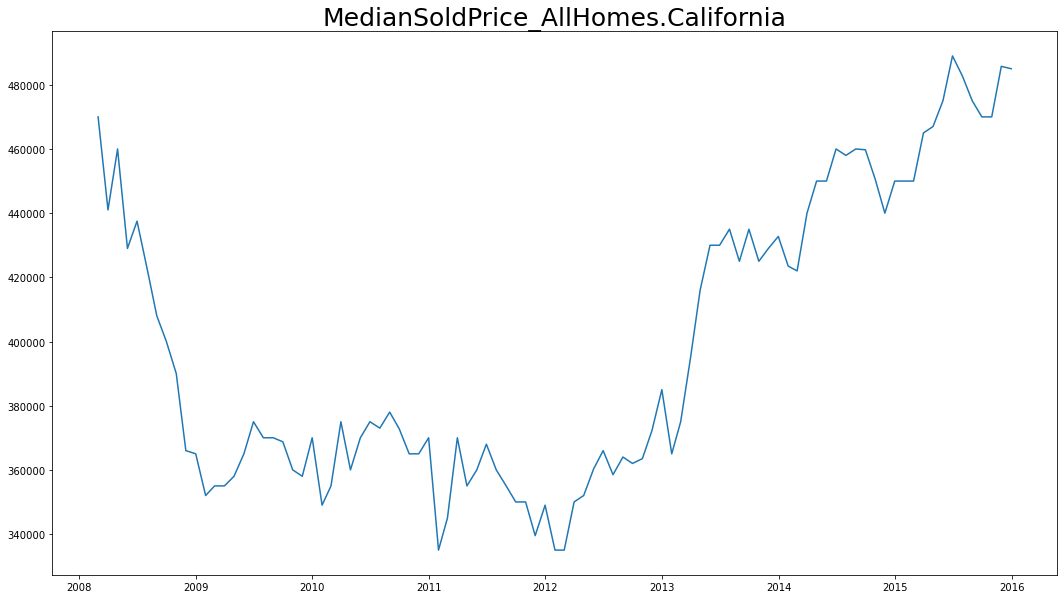

In [8]:
fig, ax = plt.subplots(figsize = (18,10))
ax.plot(hist.index, hist['MedianSoldPrice_AllHomes.California'])
ax.set_title("MedianSoldPrice_AllHomes.California", fontsize = 25)
plt.show()

# ETS

In [9]:
hist = df[df.Date < "2016-01-01"].copy()
test = df[df.Date >= "2016-01-01"].copy()

trend_types = ["add", "mul", None]
seasonal_types = ["add", "mul"]

for t_type in trend_types:
    for s_type in seasonal_types:
        print(t_type, s_type)
        print("RMSE: ", evaluate_ets_model_rmse(hist['MedianSoldPrice_AllHomes.California'], t_type, s_type))

add add
RMSE:  10999.887995154593
add mul
RMSE:  11151.502051083095
mul add
RMSE:  1.6464478238761487e+84
mul mul
RMSE:  1.1834489650777132e+100
None add
RMSE:  10339.500394850313
None mul
RMSE:  10759.152129921094


### Takeaway
Best model using ETS is No Trend, Additive Seasonality, with a one-step cross validation RMSE of 10339.500394850313. 

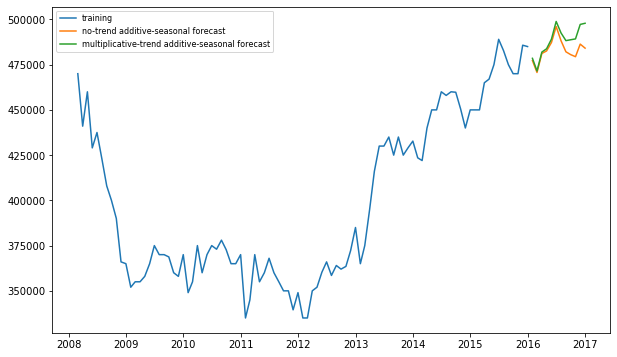

In [10]:
hist = df[df.Date < "2016-01-01"].copy()
test = df[df.Date >= "2016-01-01"].copy()
hist=hist.set_index(['Date'])
test=test.set_index(['Date'])

model = ExponentialSmoothing(hist['MedianSoldPrice_AllHomes.California'], 
                             trend=None, 
                             seasonal='add', 
                             seasonal_periods=12).fit()
pred = model.forecast(len(test))

model2 = ExponentialSmoothing(hist['MedianSoldPrice_AllHomes.California'], 
                             trend='mul', 
                             seasonal='add', 
                             seasonal_periods=12).fit()
pred2 = model2.forecast(len(test))

f, ax = plt.subplots(figsize=(10,6))
plt.plot(hist['MedianSoldPrice_AllHomes.California'], label='training')
plt.plot(pred, label='no-trend additive-seasonal forecast')
plt.plot(pred2, label='multiplicative-trend additive-seasonal forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [11]:
# Final Model Comparisons
test=pd.read_csv('test.csv')['Median House Price']
print("no-trend, additive model")
print(np.sqrt(skmetrics.mean_squared_error(test, pred)))
print("multiplicative-trend, additive model")
print(np.sqrt(skmetrics.mean_squared_error(test, pred2)))

no-trend, additive model
21605.851304793516
multiplicative-trend, additive model
15860.414991865631


# SARIMAX

In [12]:
input_df = df[['Date','MedianSoldPrice_AllHomes.California','UnemploymentRate']]

hist = input_df[input_df.Date < "2016-01-01"].copy()
test = input_df[input_df.Date >= "2016-01-01"].copy()
hist=hist.set_index(['Date'])
test=test.set_index(['Date'])

sc = StandardScaler()
train_sc = sc.fit_transform(hist)
test_sc = sc.transform(test)

hist_1d = hist.diff()[1:]
hist_2d = hist_1d.diff()[1:]

### Diff-0

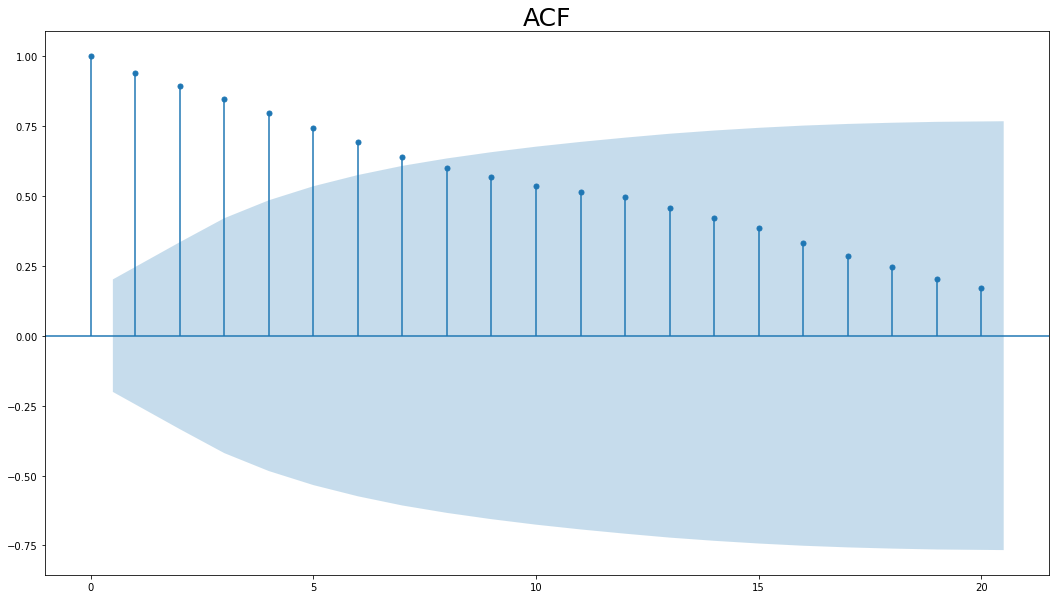

In [13]:
fig, ax = plt.subplots(figsize = (18,10))
plot_acf(hist['MedianSoldPrice_AllHomes.California'],ax = ax,lags = 20)
ax.title.set_fontsize(25)
ax.title.set_text('ACF')
plt.show()

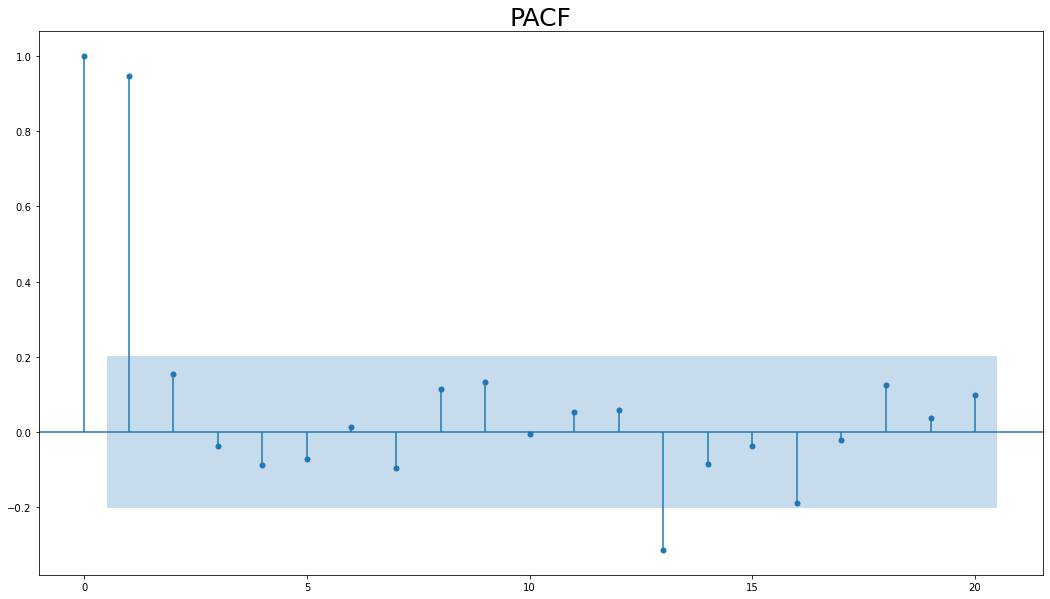

In [14]:
fig, ax = plt.subplots(figsize = (18,10))
plot_pacf(hist['MedianSoldPrice_AllHomes.California'],ax = ax,lags = 20)
ax.title.set_fontsize(25)
ax.title.set_text('PACF')
plt.show()

### Diff-1

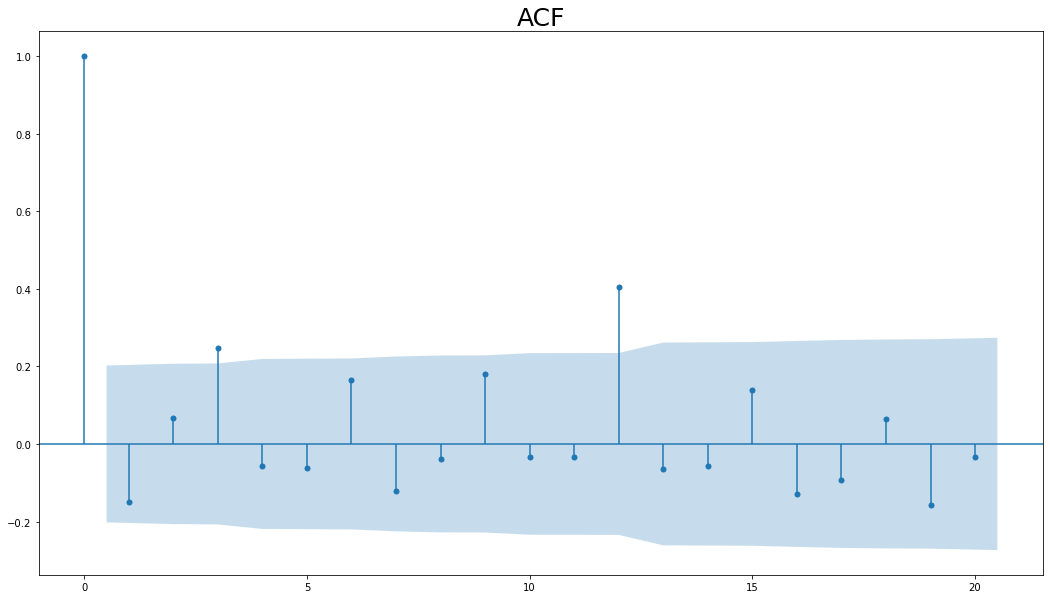

In [15]:
fig, ax = plt.subplots(figsize = (18,10))
plot_acf(hist_1d['MedianSoldPrice_AllHomes.California'],ax = ax,lags = 20)
ax.title.set_fontsize(25)
ax.title.set_text('ACF')
plt.show()

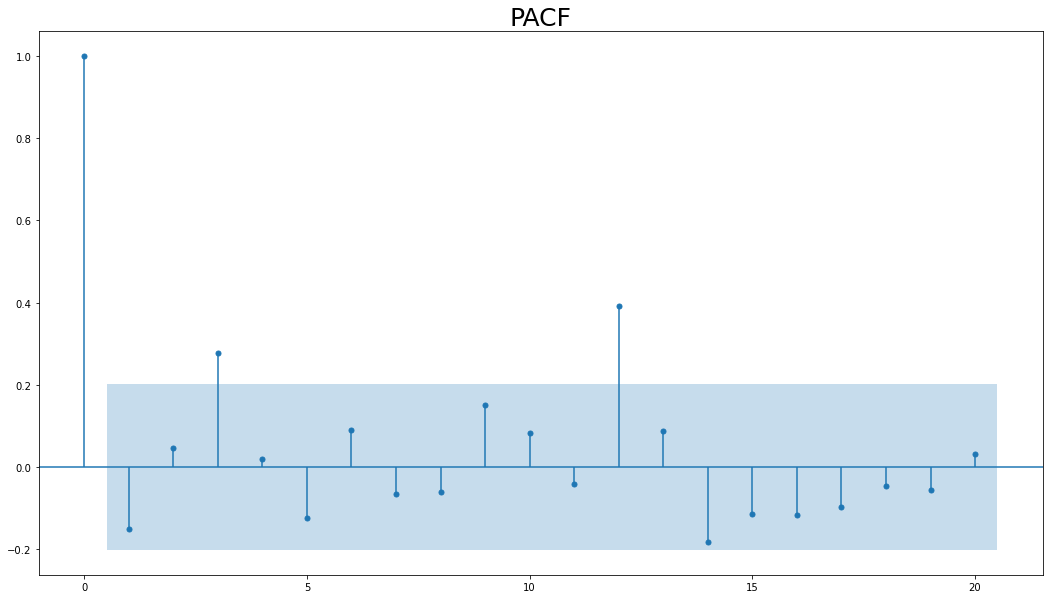

In [16]:
fig, ax = plt.subplots(figsize = (18,10))
plot_pacf(hist_1d['MedianSoldPrice_AllHomes.California'],ax = ax,lags = 20)
ax.title.set_fontsize(25)
ax.title.set_text('PACF')
plt.show()

### Diff-2

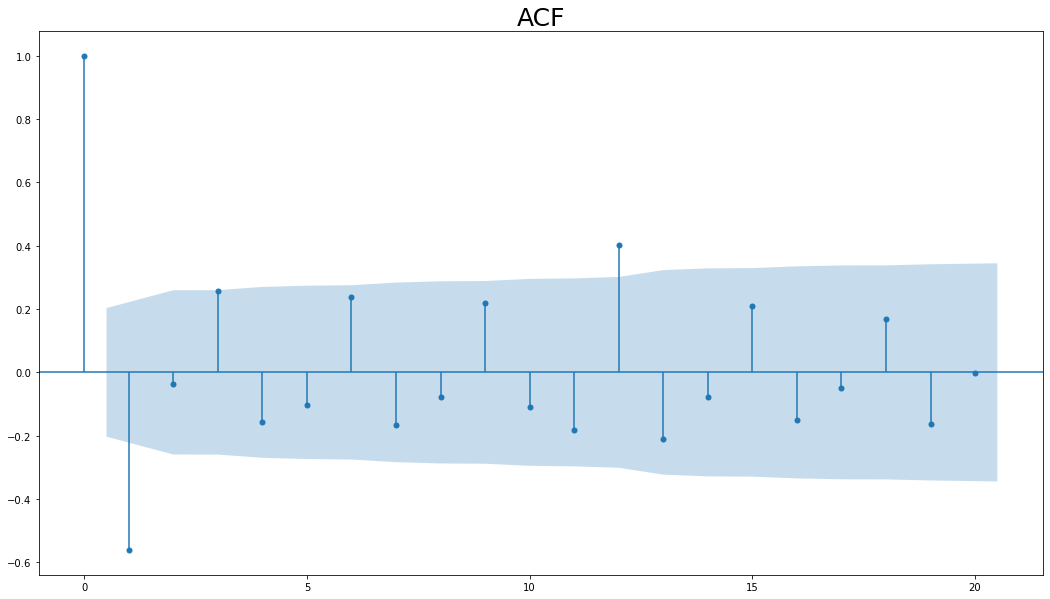

In [17]:
fig, ax = plt.subplots(figsize = (18,10))
plot_acf(hist_2d['MedianSoldPrice_AllHomes.California'],ax = ax,lags = 20)
ax.title.set_fontsize(25)
ax.title.set_text('ACF')
plt.show()

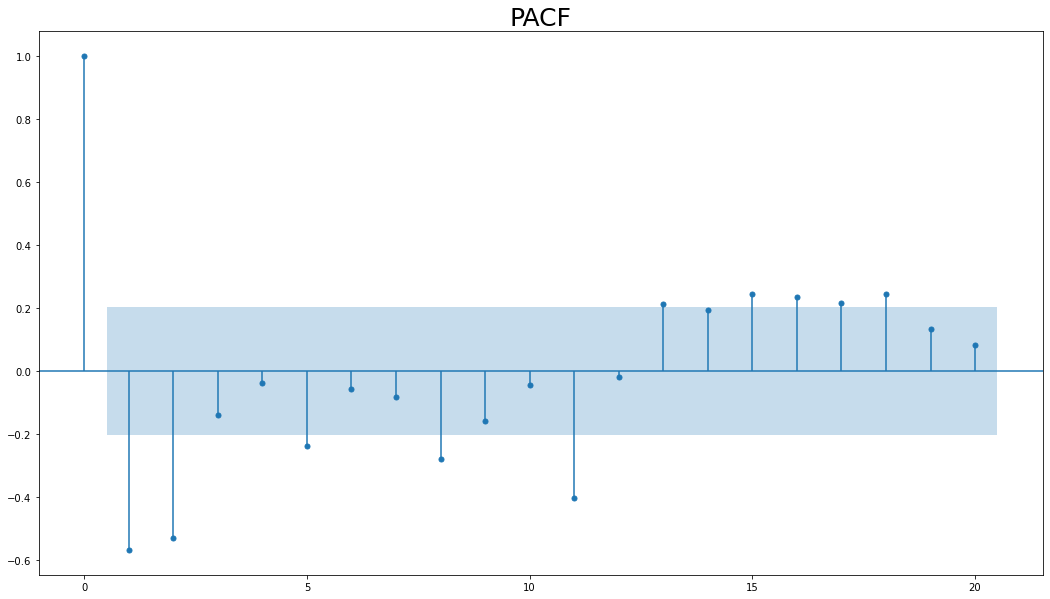

In [18]:
fig, ax = plt.subplots(figsize = (18,10))
plot_pacf(hist_2d['MedianSoldPrice_AllHomes.California'],ax = ax,lags = 20)
ax.title.set_fontsize(25)
ax.title.set_text('PACF')
plt.show()

Differencing of 1 and 2 are all working well so we try D=1 and D=2.  
The reason we pick SARIMAX is we can pick an exogenous variable as mortage and unemployment are potential influencers in this case

### Auto Arima Model Selection

### Take unemployment as exogenous variable

In [19]:
model=auto_arima(train_sc[:,-2], 
                 exogenous= train_sc[:,-1:], # UnemploymentRate as exogenous variable
                 start_p=0, start_q=0, 
                 max_p=5, max_q=5, 
                 max_d=3,
                 trace=True,seasonal=True,D=1,m=12,
                 error_action='ignore', 
                 suppress_warnings=True,information_criterion='oob', n_jobs = -1)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=177.299, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=13.487, Time=0.28 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=116.599, Time=0.16 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=179.146, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=12.836, Time=0.08 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=12.283, Time=0.39 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=1.78 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=175.791, Time=0.16 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=9.364, Time=0.38 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(2,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=2.11 sec


In [20]:
evaluate_sarima(hist['MedianSoldPrice_AllHomes.California'],(4,0,1),(2,1,0,12))

100%|███████████████████████████████████████████████| 19/19 [00:32<00:00,  1.70s/it]


25281.855145854

In [21]:
model=auto_arima(train_sc[:,-2], 
                 exogenous= train_sc[:,-1:], # UnemploymentRate as exogenous variable
                 start_p=0, start_q=0, 
                 max_p=5, max_q=5, 
                 max_d=3,
                 trace=True,seasonal=True,D=2,m=12,
                 error_action='ignore', 
                 suppress_warnings=True,information_criterion='oob', n_jobs = -1)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,2,1)[12]             : AIC=inf, Time=0.68 sec
 ARIMA(0,0,0)(0,2,0)[12]             : AIC=187.256, Time=0.05 sec
 ARIMA(1,0,0)(1,2,0)[12]             : AIC=46.601, Time=0.51 sec
 ARIMA(0,0,1)(0,2,1)[12]             : AIC=126.467, Time=0.50 sec
 ARIMA(1,0,0)(0,2,0)[12]             : AIC=59.462, Time=0.11 sec
 ARIMA(1,0,0)(2,2,0)[12]             : AIC=39.575, Time=0.97 sec
 ARIMA(1,0,0)(2,2,1)[12]             : AIC=41.455, Time=1.59 sec
 ARIMA(1,0,0)(1,2,1)[12]             : AIC=40.934, Time=1.00 sec
 ARIMA(0,0,0)(2,2,0)[12]             : AIC=166.925, Time=0.38 sec
 ARIMA(2,0,0)(2,2,0)[12]             : AIC=inf, Time=1.39 sec
 ARIMA(1,0,1)(2,2,0)[12]             : AIC=37.115, Time=1.47 sec
 ARIMA(1,0,1)(1,2,0)[12]             : AIC=47.582, Time=0.52 sec
 ARIMA(1,0,1)(2,2,1)[12]             : AIC=38.868, Time=2.22 sec
 ARIMA(1,0,1)(1,2,1)[12]             : AIC=40.249, Time=1.73 sec
 ARIMA(0,0,1)(2,2,0)[12]             : AIC=124.273

In [22]:
evaluate_sarima(hist['MedianSoldPrice_AllHomes.California'],(2,0,3),(2,2,0,12))

100%|███████████████████████████████████████████████| 19/19 [00:29<00:00,  1.54s/it]


12220.998975817705

### when choose unemployment as exogenous variable, the best model is (2,0,3),(2,2,0,12)


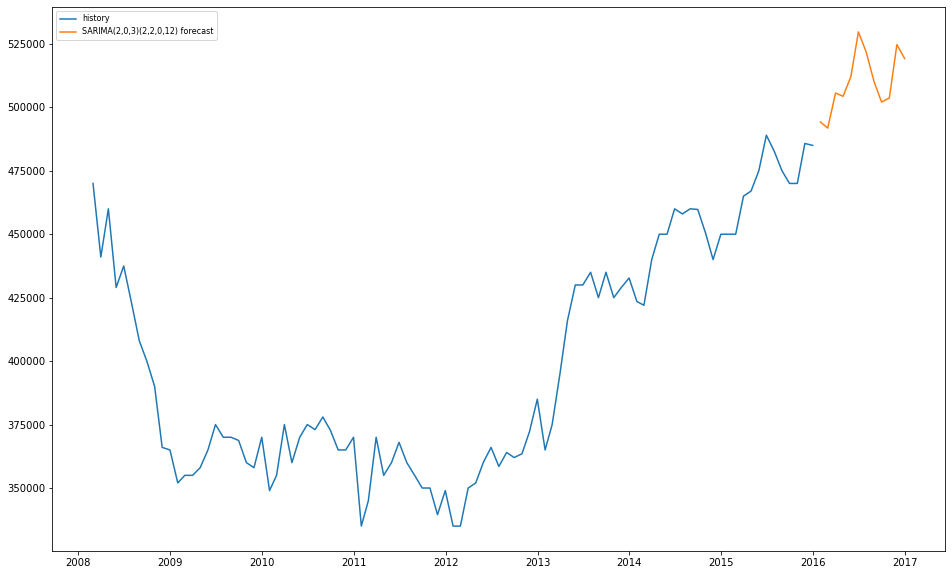

In [23]:
plt.figure(figsize=(16,10))
mod2 = sm.tsa.statespace.SARIMAX(hist['MedianSoldPrice_AllHomes.California'],order=(2,0,3),seasonal_order=(2,2,0,12))
res2 = mod2.fit(disp=False)
pred2=res2.predict(start=len(hist), end=len(hist)+len(test)-1)
plt.plot(hist['MedianSoldPrice_AllHomes.California'], label='history')
plt.plot(pred2, label='SARIMA(2,0,3)(2,2,0,12) forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [24]:
test=pd.read_csv('test.csv')['Median House Price']

### Take Mortage as exogenous variable

In [25]:
input_df = df[['Date','MedianSoldPrice_AllHomes.California','MedianMortageRate']]

hist = input_df[input_df.Date < "2016-01-01"].copy()
test = input_df[input_df.Date >= "2016-01-01"].copy()
hist=hist.set_index(['Date'])
test=test.set_index(['Date'])

sc = StandardScaler()
train_sc = sc.fit_transform(hist)
test_sc = sc.transform(test)

In [26]:
model=auto_arima(train_sc[:,-2], 
                 exogenous= train_sc[:,-1:], # Mortagerate as exogenous variable
                 start_p=0, start_q=0, 
                 max_p=5, max_q=5, 
                 max_d=3,
                 trace=True,seasonal=True,D=2,m=12,
                 error_action='ignore', 
                 suppress_warnings=True,information_criterion='oob', n_jobs = -1)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,2,1)[12]             : AIC=177.448, Time=0.35 sec
 ARIMA(0,0,0)(0,2,0)[12]             : AIC=186.229, Time=0.06 sec
 ARIMA(1,0,0)(1,2,0)[12]             : AIC=44.473, Time=0.46 sec
 ARIMA(0,0,1)(0,2,1)[12]             : AIC=124.915, Time=0.39 sec
 ARIMA(1,0,0)(0,2,0)[12]             : AIC=58.921, Time=0.11 sec
 ARIMA(1,0,0)(2,2,0)[12]             : AIC=40.200, Time=1.05 sec
 ARIMA(1,0,0)(2,2,1)[12]             : AIC=40.977, Time=1.62 sec
 ARIMA(1,0,0)(1,2,1)[12]             : AIC=39.159, Time=2.01 sec
 ARIMA(1,0,0)(0,2,1)[12]             : AIC=inf, Time=1.34 sec
 ARIMA(1,0,0)(1,2,2)[12]             : AIC=inf, Time=2.20 sec
 ARIMA(1,0,0)(0,2,2)[12]             : AIC=39.156, Time=1.23 sec
 ARIMA(0,0,0)(0,2,2)[12]             : AIC=175.119, Time=0.43 sec
 ARIMA(2,0,0)(0,2,2)[12]             : AIC=37.963, Time=1.87 sec
 ARIMA(2,0,0)(0,2,1)[12]             : AIC=inf, Time=1.05 sec
 ARIMA(2,0,0)(1,2,2)[12]             : AIC=inf, Time

In [27]:
evaluate_sarima(hist['MedianSoldPrice_AllHomes.California'],(2,0,0),(0,2,2,12))

100%|███████████████████████████████████████████████| 19/19 [00:16<00:00,  1.12it/s]


10567.653480589208

In [28]:
model=auto_arima(train_sc[:,-2], 
                 exogenous= train_sc[:,-1:], # Mortagerate as exogenous variable
                 start_p=0, start_q=0, 
                 max_p=5, max_q=5, 
                 max_d=3,
                 trace=True,seasonal=True,D=1,m=12,
                 error_action='ignore', 
                 suppress_warnings=True,information_criterion='oob', n_jobs = -1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=2.516, Time=0.31 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3.503, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1.758, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1.487, Time=0.20 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3.325, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2.253, Time=0.26 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1.710, Time=1.26 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3.116, Time=0.13 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=3.474, Time=1.43 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2.708, Time=0.16 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=0.205, Time=0.25 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=3.371, Time=0.08 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1.207, Time=0.38 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=0.654, Time=1.10 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=2.572, Time=0.27 s

In [29]:
evaluate_sarima(hist['MedianSoldPrice_AllHomes.California'],(1,1,2),(0,1,1,12))

100%|███████████████████████████████████████████████| 19/19 [00:05<00:00,  3.72it/s]


9753.030819514048

### The best model in this case is (1,1,2),(0,1,1,12)

### Take both Mortage and Unemployment as exogenous variables

In [30]:
input_df = df[['Date','MedianSoldPrice_AllHomes.California','MedianMortageRate','UnemploymentRate']]

hist = input_df[input_df.Date < "2016-01-01"].copy()
test = input_df[input_df.Date >= "2016-01-01"].copy()
hist=hist.set_index(['Date'])
test=test.set_index(['Date'])

sc = StandardScaler()
train_sc = sc.fit_transform(hist)
test_sc = sc.transform(test)

In [31]:
model=auto_arima(train_sc[:,-3], 
                 exogenous= train_sc[:,-3:], # Mortagerate and unemployment as exogenous variables
                 start_p=0, start_q=0, 
                 max_p=5, max_q=5, 
                 max_d=3,
                 trace=True,seasonal=True,D=1,m=12,
                 error_action='ignore', 
                 suppress_warnings=True,information_criterion='oob', n_jobs = -1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=-1426.134, Time=0.71 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-1651.956, Time=0.20 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-1594.603, Time=0.87 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-1565.718, Time=0.26 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-1537.263, Time=0.54 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-1630.408, Time=0.21 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-707.836, Time=0.12 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-1556.223, Time=0.36 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-1647.956, Time=0.31 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=-1653.430, Time=0.20 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=-1546.823, Time=1.36 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=-1629.687, Time=1.04 sec
 ARIMA(0,1,0)(1,1,1)[12] intercept   : AIC=-314.687, Time=0.34 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=-1651.430, Time=0.24 sec
 ARIMA(

In [32]:
evaluate_sarima(hist['MedianSoldPrice_AllHomes.California'],(0,1,0),(0,1,0,12))

100%|███████████████████████████████████████████████| 19/19 [00:00<00:00, 49.99it/s]


10038.413063931233

In [33]:
model=auto_arima(train_sc[:,-3], 
                 exogenous= train_sc[:,-3:], # Mortagerate and unemployment as exogenous variables
                 start_p=0, start_q=0, 
                 max_p=5, max_q=5, 
                 max_d=3,
                 trace=True,seasonal=True,D=2,m=12,
                 error_action='ignore', 
                 suppress_warnings=True,information_criterion='oob', n_jobs = -1)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,2,1)[12]             : AIC=-1491.064, Time=1.54 sec
 ARIMA(0,0,0)(0,2,0)[12]             : AIC=-1486.204, Time=0.13 sec
 ARIMA(1,0,0)(1,2,0)[12]             : AIC=-1485.095, Time=0.66 sec
 ARIMA(0,0,1)(0,2,1)[12]             : AIC=-1409.540, Time=2.49 sec
 ARIMA(0,0,0)(0,2,1)[12]             : AIC=-1494.646, Time=1.18 sec
 ARIMA(0,0,0)(0,2,2)[12]             : AIC=-1482.204, Time=0.96 sec
 ARIMA(0,0,0)(1,2,0)[12]             : AIC=-1493.749, Time=0.79 sec
 ARIMA(0,0,0)(1,2,2)[12]             : AIC=-1480.204, Time=0.93 sec
 ARIMA(1,0,0)(0,2,1)[12]             : AIC=-1484.733, Time=0.50 sec
 ARIMA(1,0,1)(0,2,1)[12]             : AIC=-1356.018, Time=1.69 sec
 ARIMA(0,0,0)(0,2,1)[12] intercept   : AIC=-1485.472, Time=0.56 sec

Best model:  ARIMA(0,0,0)(0,2,1)[12]          
Total fit time: 11.423 seconds


In [34]:
evaluate_sarima(hist['MedianSoldPrice_AllHomes.California'],(0,0,0),(1,2,0,12))

100%|███████████████████████████████████████████████| 19/19 [00:01<00:00,  9.65it/s]


25427.934734958904

### The best model in this case is (0,1,0),(0,1,0,12)

### Based on the CV above the best model is take Mortgage Rate as exogenous variable SARIMAX(1,1,2),(0,1,1,12)

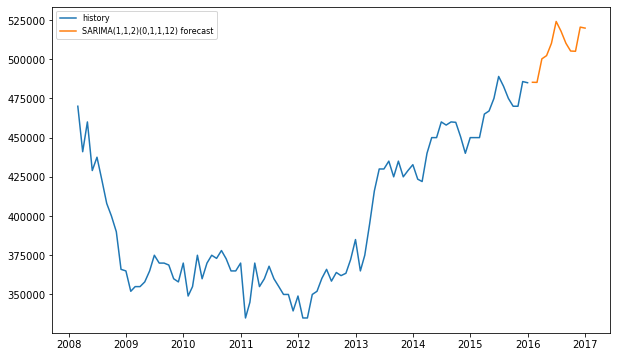

In [35]:
plt.figure(figsize=(10,6))
mod2 = sm.tsa.statespace.SARIMAX(hist['MedianSoldPrice_AllHomes.California'],order=(1,1,2),seasonal_order=(0,1,1,12))
res2 = mod2.fit(disp=False)
pred2=res2.predict(start=len(hist), end=len(hist)+len(test)-1)
plt.plot(hist['MedianSoldPrice_AllHomes.California'], label='history')
plt.plot(pred2, label='SARIMA(1,1,2)(0,1,1,12) forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Calculate RMSE of forecasting data

In [36]:
test=pd.read_csv('test.csv')['Median House Price']

In [37]:
np.sqrt(skmetrics.mean_squared_error(test, pred2))

12578.392476486599

# FB Prophet

One limitation of the FB Prophet model is that it works well on Univariate data

In [58]:
input_df = df[['Date','MedianSoldPrice_AllHomes.California']]
test_file = pd.read_csv('test.csv')

hist = input_df.iloc[:95].copy()
test = test_file.copy()



In [59]:
hist=hist.rename(columns={'Date':'ds','MedianSoldPrice_AllHomes.California':'y'})

In [60]:
hist.tail(15)

,ds,y
80,2014-10-31,450500.0
81,2014-11-30,440000.0
82,2014-12-31,450000.0
83,2015-01-31,450000.0
84,2015-02-28,450000.0
85,2015-03-31,465000.0
86,2015-04-30,467000.0
87,2015-05-31,475000.0
88,2015-06-30,489000.0
89,2015-07-31,482750.0


In [61]:
model_1=Prophet()
model_1=model_1.add_seasonality(name='monthly', period=12, fourier_order=5)
model_1.fit(hist)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -135.274
Iteration  1. Log joint probability =    75.3859. Improved by 210.66.
Iteration  2. Log joint probability =    136.815. Improved by 61.4292.
Iteration  3. Log joint probability =    191.426. Improved by 54.6112.
Iteration  4. Log joint probability =    205.684. Improved by 14.2582.
Iteration  5. Log joint probability =    205.732. Improved by 0.0473862.
Iteration  6. Log joint probability =    239.673. Improved by 33.9409.
Iteration  7. Log joint probability =    239.958. Improved by 0.284992.
Iteration  8. Log joint probability =    240.185. Improved by 0.227327.
Iteration  9. Log joint probability =    240.199. Improved by 0.0135121.
Iteration 10. Log joint probability =    240.415. Improved by 0.216058.
Iteration 11. Log joint probability =    240.449. Improved by 0.0343598.
Iteration 12. Log joint probability =    240.517. Improved by 0.0682366.
Iteration 13. Log joint probability =    240.862. Improved by 0.344675.
Iteration 14. Log joint 

In [62]:
future = model_1.make_future_dataframe(periods=len(test),freq='M')
forecast = model_1.predict(future)

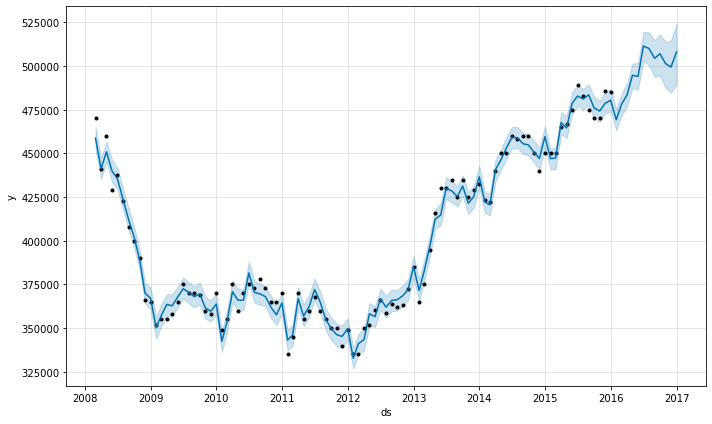

In [63]:
model_1.plot(forecast)
plt.show()

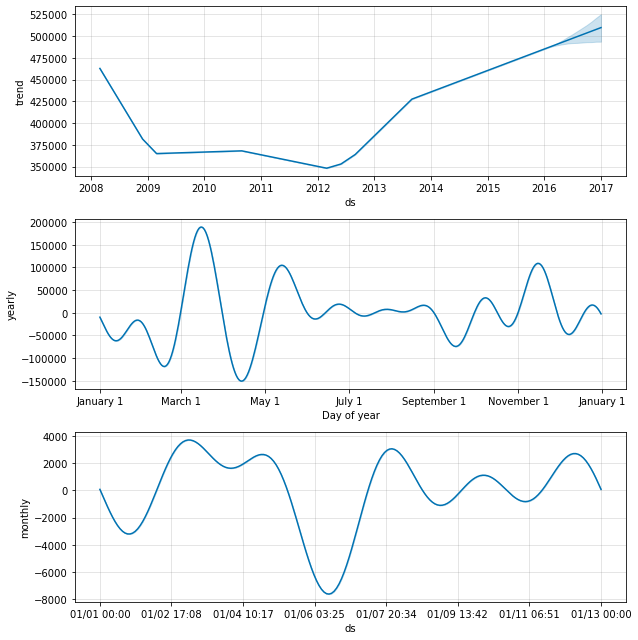

In [64]:
model_1.plot_components(forecast)
plt.show()

In [65]:
forecast.tail(15)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
92,2015-10-31,481002.297657,467947.618962,480109.296562,481002.297657,481002.297657,-6732.076423,-6732.076423,-6732.076423,2558.726976,2558.726976,2558.726976,-9290.803398,-9290.803398,-9290.803398,0.0,0.0,0.0,474270.221234
93,2015-11-30,483029.326373,472759.236130,485057.894270,483029.326373,483029.326373,-4349.711898,-4349.711898,-4349.711898,-654.283214,-654.283214,-654.283214,-3695.428684,-3695.428684,-3695.428684,0.0,0.0,0.0,478679.614475
94,2015-12-31,485123.922714,474092.996448,486815.866940,485123.922714,485123.922714,-4653.134903,-4653.134903,-4653.134903,-5123.114432,-5123.114432,-5123.114432,469.979529,469.979529,469.979529,0.0,0.0,0.0,480470.787810
95,2016-01-31,487218.519054,463180.754621,475374.065746,487151.174224,487250.124421,-17969.851286,-17969.851286,-17969.851286,69.268230,69.268230,69.268230,-18039.119516,-18039.119516,-18039.119516,0.0,0.0,0.0,469248.667768
96,2016-02-29,489177.980147,471528.652825,484256.724467,488602.747361,489687.418057,-11094.466086,-11094.466086,-11094.466086,-5123.114432,-5123.114432,-5123.114432,-5971.351654,-5971.351654,-5971.351654,0.0,0.0,0.0,478083.514060
97,2016-03-31,491272.576487,476834.339496,490031.975946,489785.028638,492665.936227,-7808.106219,-7808.106219,-7808.106219,69.268230,69.268230,69.268230,-7877.374448,-7877.374448,-7877.374448,0.0,0.0,0.0,483464.470268
98,2016-04-30,493299.605203,487609.991596,501420.596910,490726.563956,495671.968912,1426.629171,1426.629171,1426.629171,-4599.446759,-4599.446759,-4599.446759,6026.075930,6026.075930,6026.075930,0.0,0.0,0.0,494726.234374
99,2016-05-31,495394.201544,486449.709960,501755.493351,491587.196578,499126.683985,-1296.264491,-1296.264491,-1296.264491,-2420.722981,-2420.722981,-2420.722981,1124.458490,1124.458490,1124.458490,0.0,0.0,0.0,494097.937052
100,2016-06-30,497421.230260,503153.786825,519569.473334,492072.213868,502239.597180,14072.200845,14072.200845,14072.200845,3049.545684,3049.545684,3049.545684,11022.655161,11022.655161,11022.655161,0.0,0.0,0.0,511493.431105
101,2016-07-31,499515.826600,500392.865139,519276.201183,492266.128539,505778.361355,10535.944265,10535.944265,10535.944265,3579.514162,3579.514162,3579.514162,6956.430103,6956.430103,6956.430103,0.0,0.0,0.0,510051.770865


In [66]:
yhat = forecast['yhat']
np.sqrt(skmetrics.mean_squared_error(test['Median House Price'], yhat[95:]))

8603.082544533638